<a href="https://colab.research.google.com/github/beaten-by-the-market/dart_disclosure/blob/main/buyback_resale_blockdeal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 자사주 **처분**에서 시간외대량매매는 얼마나 있을까?

[**10년간 자사주 매입현황 포스팅(링크)**{: style="color: #4682B4;"}](https://beaten-by-the-market.github.io/%ED%95%9C%EA%B5%AD%EC%8B%9C%EC%9E%A5/kospi-buyback-insight/#%EC%9E%90%EC%82%AC%EC%A3%BC%EC%B7%A8%EB%93%9D-%EC%9E%A5%EB%82%B4-vs-%EC%9E%A5%EC%99%B8-%EA%B5%AC%EB%B6%84%EC%9E%90-%EB%8B%AC%EA%B8%B0)과 [**자사주 매입: 시간외대량매매의 비중은 얼마일까?(링크)**{: style="color: #4682B4;"}](https://beaten-by-the-market.github.io/%EA%B5%AD%EB%82%B4%EC%8B%9C%EC%9E%A5/buyback_blockdeal/)이 후속 포스팅입니다. 이번에는 자기주식을 처분할 때 시간외대량매매의 비중이 얼마나 될지를 알아보도록 하겠습니다.<br>
앞서 우리는 자기주식을 **매입**하는 사유로 기업이 가장 많이 공시하는 것은 **주식 가치 제고**{: style="color: #4682B4;"}이므로 **장내에서 많이 매수할 것이라 추측해보았습니다.**{: style="color: #4682B4;"} 그리고 **실제로 전수조사를 통해 자기주식 매입에 시간외대량매매는 사실상 이용되지 않는다는 것을 확인했습니다.**{: style="color: #4682B4;"}<br>
반면, 자기주식을 부득이하게 처분해야할 때 회사는 주가가 최대한 하락하지 않길 원하기 때문에 **자사주를 매도할 때는 장내가 아닌 방식으로, 예를 들어 시간외대량매매를 활용할 수 있겠다는 추측을 했습니다.**{: style="color: #4682B4;"} 이제 다시 시장 전수조사를 통해 확인해보도록 하겠습니다.

### (복습) **시간외대량매매**란?
이전 포스팅의 [**시간외대량매매란?(링크)**{: style="color: #4682B4;"}](https://beaten-by-the-market.github.io/%EA%B5%AD%EB%82%B4%EC%8B%9C%EC%9E%A5/buyback_blockdeal/#%EC%8B%9C%EA%B0%84%EC%99%B8%EB%8C%80%EB%9F%89%EB%A7%A4%EB%A7%A4%EB%9E%80) 를 통해 확인하실 수 있습니다.

### 코랩 환경에서 데이터 수집, 시각화를 하기 위해 필요한 라이브러리를 설치

In [1]:
# 필요한 라이브러리 설치
import pandas as pd
import requests
from io import BytesIO, StringIO
from time import sleep
from tqdm import tqdm
from bs4 import BeautifulSoup
import json
import re
import numpy as np
from datetime import datetime

# 시각화 관련
!pip install adjustText
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from adjustText import adjust_text

# 한글 폰트 설정 (Google Colab 환경에서)
!apt-get update -qq
!apt-get install fonts-nanum* -qq

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=10)

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-nanum.
(Reading database ... 124926 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-3_all.deb ...
Unpacking fonts-nanum-coding (2.5-3) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-7_all.deb ...
Unpacking fonts-nanum-eco (1.000-7) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20200506-1_all.deb ...
Unpacking fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Setting up fo

## 코스피 자기주식 **직접 처분** 통계 불러오기
우리는 이전에 포스팅한 [**10년간 코스피 자사주 직접 ‘처분’ 현황(링크)**{: style="color: #4682B4;"}](https://beaten-by-the-market.github.io/%ED%95%9C%EA%B5%AD%EC%8B%9C%EC%9E%A5/kospi_dart_buyback_resale/)에서 코스피시장의 자기주식 처분현황을 확인한 바 있었습니다. 처분현황을 조사하는 과정에서 확인한 포인트를 짧게 wrap-up해보겠습니다.
1. 취득공시와 달리 **처분공시**{: style="color: #4682B4;"}는 **주식의 매매방법을 세분화**{: style="color: #4682B4;"}해놓았습니다.<br>
* 자사주취득공시 : 처분방식을 ***하나의 칸에 free text로 기재***합니다.
* 자사주처분공시 : 처분방식을 ***시장, 시간외대량, 장외, 기타로 구분***을 하였고, 각각의 방식으로 처분할 수량을 기재하도록 하였습니다.<br>
↪ **처분공시 서식에서는 데이터 활용성이 높아졌습니다!**
<br>

2. 최종공시에도 **오타가 존재**하였습니다.<br>***가장 중요한 숫자(처분예정수량 합계와 처분예정금액 합계)***에는 오타가 없었습니다만, **처분방법별 수량을 기재하는 과정에서 2개의 상장사가 오타**{: style="color: #4682B4;"}를 냈습니다. 그 오타의 수준이 매우 커서 데이터 전체가 왜곡되었습니다. <br>
어떤 사유로 오타를 냈는지 확인이 불가능했다면 데이터 분석 자체를 진행하기 힘들었겠지만, **다행히도 두 케이스 모두 오타의 사유가 추정가능했고, 데이터를 전처리하여 분석을 진행**했습니다.


In [36]:
# 데이터 검색기준 설정하기
start_y = "2015"
end_y = "2024"
corp_type = "P" #유가는 "P", 코스닥은 "A", 유가및코스닥은 ["P", "A"] 입력
reportCode = "11333" #직접취득 11332, 직접처분 11333, 신탁취득 11334, 신탁해지 11335

# 기본 params 템플릿
params = {
    "pageIndex": "1",
    "pageSize": "10",
    "pageUnit": "10",
    "recordCountPerPage": "1000",
    "sortStdr": "crp",
    "sortOrdr": "asc",
    "sumSortStdr": "",
    "sumSortOrdr": "asc",
    "textCrpCik": "",
    "bgnDe": f"{start_y}-01-01",
    "endDe": f"{end_y}-12-31",
    "textCrpNm": "",
    "startDate": f"{start_y}-01-01",
    "endDate": f"{end_y}-12-31",
    "reportCode": f"{reportCode}",
    "corpType" : f"{corp_type}"
}

# 결과 출력
params

{'pageIndex': '1',
 'pageSize': '10',
 'pageUnit': '10',
 'recordCountPerPage': '1000',
 'sortStdr': 'crp',
 'sortOrdr': 'asc',
 'sumSortStdr': '',
 'sumSortOrdr': 'asc',
 'textCrpCik': '',
 'bgnDe': '2015-01-01',
 'endDe': '2024-12-31',
 'textCrpNm': '',
 'startDate': '2015-01-01',
 'endDate': '2024-12-31',
 'reportCode': '11333',
 'corpType': 'P'}

In [37]:
# 첫번째 페이지를 기준으로 크롤링
url = 'https://opendart.fss.or.kr/disclosureinfo/mainMatter/list.do'
req = requests.post(url, params = params)
content = req.content.decode('utf-8')

# beautifulsoup 객체로 전환
soup = BeautifulSoup(content, 'html.parser')

# 끝에서 두번째 div 태그에 페이지 정보가 있음
output_string = soup.find_all('div')[-2].text

import re

# 정규 표현식을 사용하여 숫자 추출
# 백만단위 건수는 아닐거라는 가정임. 즉, 콤마가 많아도 하나만 있다는 가정임
match = re.match(r"\[(\d+)/(\d+)\] \[총 (\d+)?,?(\d+)건\]", output_string)

if match:
    total_page = int(match.group(2))
    total_counts_before_comma = match.group(3)
    total_counts_after_comma = match.group(4)
    print(f"total_page: {total_page}")
    print(f"total_counts: {total_counts_before_comma},{total_counts_after_comma}")
else:
    print("출력물 형식이 올바르지 않습니다.")

total_page: 11
total_counts: 1,008


In [38]:
# 데이터를 수집할 빈 데이터프레임(마스터 데이터프레임) 생성
df_dart_buyback = pd.DataFrame()

# 이미 받아놓은 값(content)에서 첫번째 페이지의 데이터프레임 파싱
html_string = StringIO(content)  # StringIO로 HTML 문자열 감싸기
df_loop = pd.read_html(html_string)[0]

# 마스터 데이터프레임에 합치기
df_dart_buyback = pd.concat([df_dart_buyback, df_loop])

for i in range(2, total_page + 1):
  page_index = str(i)
  # params 기준에서 페이지 인덱스만 수정하기
  params["pageIndex"] = page_index

  req = requests.post(url, params = params)
  content = req.content.decode('utf-8')
  html_string = StringIO(content)  # StringIO로 HTML 문자열 감싸기
  df_loop = pd.read_html(html_string)[0]

  # IP차단을 위해 쉬어가기
  sleep(1)

  # 마스터 데이터프레임에 합치기
  df_dart_buyback = pd.concat([df_dart_buyback, df_loop])

In [40]:
# 확인된 값을 바탕으로 칼럼명을 지정
df_dart_buyback.columns = ['회사명', '접수일',
                           '처분예정주식(주)_보통주식', '처분예정주식(주)_기타주식',
                           '처분 대상 주식가격(원)_보통주식', '처분 대상 주식가격(원)_기타주식',
                           '처분예정금액(원)_보통주식', '처분예정금액(원)_기타주식',
                           '처분예상기간_시작일','처분예상기간_종료일',
                           '처분목적',
                           '처분방법_시장을 통한 매도(주)',
                           '처분방법_시간외대량매매(주)',
                           '처분방법_장외처분(주)',
                           '처분방법_기타(주)',
                           '위탁투자중개업자',
                           '처분 전 자기주식 보유현황_배당가능이익 범위 내 처분(주)_보통주식',
                           '처분 전 자기주식 보유현황_배당가능이익 범위 내 처분(주)_비율(%)',
                           '처분 전 자기주식 보유현황_배당가능이익 범위 내 처분(주)_기타주식',
                           '처분 전 자기주식 보유현황_배당가능이익 범위 내 처분(주)_비율(%).1',
                           '처분 전 자기주식 보유현황_기타처분(주)_보통주식',
                           '처분 전 자기주식 보유현황_기타처분(주)_비율(%)',
                           '처분 전 자기주식 보유현황_기타처분(주)_기타주식',
                           '처분 전 자기주식 보유현황_기타처분(주)_비율(%).1',
                           '처분결정일',
                           '사외이사참석여부_참석(명)', '사외이사참석여부_불참(명)',
                           '감사 (사외이사가 아닌 감사위원) 참석여부',
                           '1일 매도 주문수량 한도_보통주식', '1일 매도 주문수량 한도_기타주식',
                           '비고']

In [41]:
# 필요한 칼럼만 선택하고 이름을 변경하여 새로운 데이터프레임 생성
df_dart_buyback = df_dart_buyback[['회사명', '접수일',
                           '처분예정주식(주)_보통주식',
                           '처분예정금액(원)_보통주식',
                           '처분예상기간_시작일','처분예상기간_종료일',
                           '처분목적',
                           '처분방법_시장을 통한 매도(주)',
                           '처분방법_시간외대량매매(주)',
                           '처분방법_장외처분(주)',
                           '처분방법_기타(주)']].copy()

df_dart_buyback.columns = ['회사명', '접수일',
                           '처분예정주식','처분예정금액','처분시작일','처분종료일',
                           '처분목적', '장내매매', '시간외대량매매', '장외매매', '기타']

# 기존에는 접수일을 datetime으로 변환 및 연도 추출하였으나,
# 공시가 정정될 경우, 연도가 바뀌는 이슈가 있었음
# 그리하여 연도의 기준은 '처분예상기간의 시작일'로 설정함

#다트 편집기를 보면 날짜를 입력하는 형태는 두가지가 있다
#(1) 2022.08.03
#(2) 2022년 08월 03일
#따라서 두번째 형태일 경우 첫번째 형태로 전환하는 함수를 생성한다
def chg_date_format(date_input) :
    if '년' in date_input:
        new_year = date_input[0:4]
        new_month = date_input[6:8]
        new_day = date_input[10:12]
        new_date = new_year + new_month + new_day
    else :
        new_date = date_input
    return new_date

#생성한 함수를 통해서 포맷을 바꿔준다
df_dart_buyback['처분시작일'] = df_dart_buyback.처분시작일.apply(lambda x : chg_date_format(x))
df_dart_buyback['처분시작일'] = pd.to_datetime(df_dart_buyback['처분시작일'], errors='coerce')
df_dart_buyback['연도'] = df_dart_buyback['처분시작일'].dt.year

# 데이터 타입 변경
df_dart_buyback['연도'] = pd.to_numeric(df_dart_buyback['연도'], errors='coerce').astype('Int64')

df_dart_buyback['처분예정주식'] = pd.to_numeric(
    df_dart_buyback['처분예정주식'], errors='coerce').fillna(0)

df_dart_buyback['처분예정금액'] = pd.to_numeric(
    df_dart_buyback['처분예정금액'], errors='coerce').fillna(0) / 1e8  # 원 -> 억 원 변환

# 맨 앞의 '유' 또는 '코' 제거, 맨 끝의 'IR' 제거
df_dart_buyback['회사명'] = df_dart_buyback['회사명'].str.replace(r'^(유|코)', '', regex=True).str.replace(r'  IR$', '', regex=True).str.replace(r'IR$', '', regex=True)


### 자사주 직접처분 데이터 시각화
우선 코스피시장의 전체적인 처분수량과 처분금액의 시각화 결과는 다음과 같았습니다.

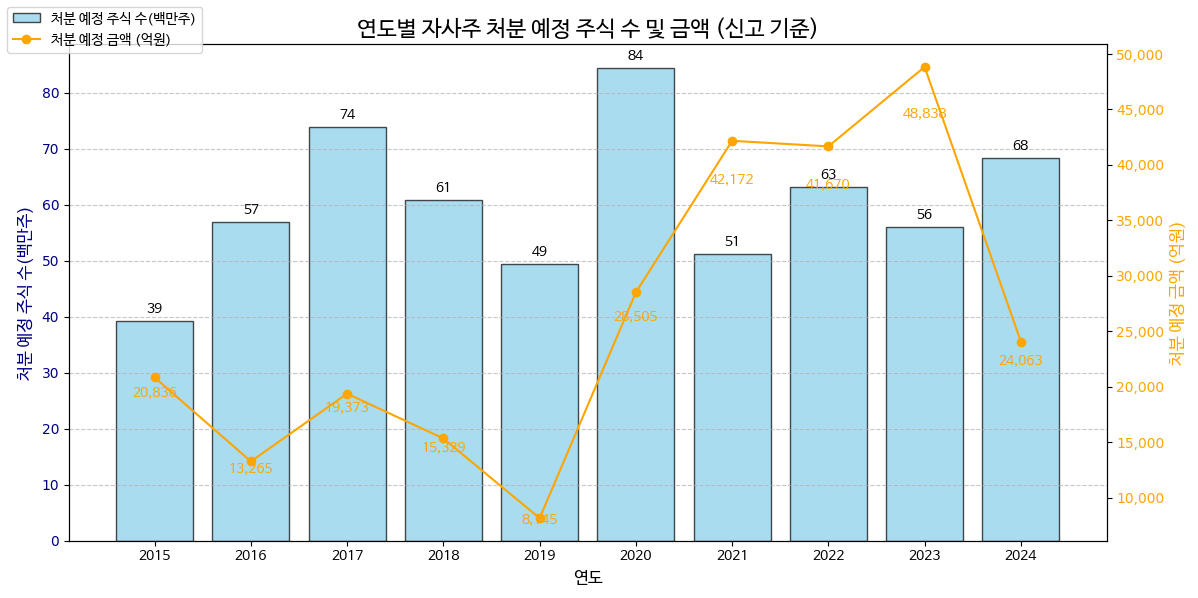

In [43]:
# 연도별 처분예정주식(주) 및 처분예정금액 집계
annual_summary = df_dart_buyback.groupby('연도').agg({
    '처분예정주식': 'sum',
    '처분예정금액': 'sum'
})

# 단위 변환
annual_summary['처분예정주식'] = annual_summary['처분예정주식'] / 1000000 # 주 -> 백만주 변환

# 그래프 크기 설정
fig, ax1 = plt.subplots(figsize=(12, 6))

# 막대 그래프: 연도별 처분 예정 주식 수
bars = ax1.bar(annual_summary.index,
               annual_summary['처분예정주식'],
               color='skyblue', edgecolor='black', alpha=0.7, label='처분 예정 주식 수(백만주)')
ax1.set_xlabel('연도', fontproperties=font, fontsize=12)
ax1.set_ylabel('처분 예정 주식 수(백만주)', fontproperties=font, fontsize=12, color='navy')
ax1.tick_params(axis='y', labelcolor='navy')

# x축 눈금 설정 (모든 연도 표시)
plt.xticks(annual_summary.index, fontproperties=font, fontsize=10)

# 데이터 라벨 추가 (막대 그래프)
texts = []
for bar in bars:
    height = bar.get_height()
    if height > 0:  # 데이터가 있는 경우에만 레이블 추가
        texts.append(ax1.text(bar.get_x() + bar.get_width() / 2., height,
                              f'{height:,.0f}', ha='center', va='bottom',
                              fontproperties=font, fontsize=10))

# 보조축 추가: 처분 예정 금액
ax2 = ax1.twinx()
line, = ax2.plot(annual_summary.index,
                 annual_summary['처분예정금액'],
                 color='orange', marker='o', label='처분 예정 금액 (억원)')
ax2.set_ylabel('처분 예정 금액 (억원)', fontproperties=font, fontsize=12, color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# y축 보조축에 천 단위 콤마 추가
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

# 선 그래프 레이블 추가
for i, value in enumerate(annual_summary['처분예정금액']):
    ax2.text(annual_summary.index[i], value*0.9, f'{value:,.0f}',
             color='orange', fontsize=10, ha='center', va='bottom', fontproperties=font)

# adjustText를 사용하여 레이블 위치 조정
adjust_text(texts, ax=ax1)

# y축 그리드 추가
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# 범례 추가
fig.legend(loc='upper left', bbox_transform=ax1.transAxes, prop=font)

# 그래프 제목 설정
plt.title('연도별 자사주 처분 예정 주식 수 및 금액 (신고 기준)', fontproperties=font, fontsize=16)

# 그래프 여백 조정
plt.tight_layout()

# 그래프 표시
plt.show()


In [45]:
# 데이터 타입 변경
columns_to_convert = ['장내매매', '시간외대량매매', '장외매매', '기타']

for col in columns_to_convert:
    df_dart_buyback[col] = pd.to_numeric(df_dart_buyback[col], errors='coerce').fillna(0)

# 연도별 방법별 처분예정주식(주) 집계
df_dart_buyback_summary = df_dart_buyback.groupby('연도').agg({
    '장내매매': 'sum',
    '시간외대량매매': 'sum',
    '장외매매': 'sum',
    '기타': 'sum'
})

### 공시에서 발견된 오타들!
이전 포스팅의 [**공시에서 발견된 오타들!(링크)**{: style="color: #4682B4;"}](https://beaten-by-the-market.github.io/%ED%95%9C%EA%B5%AD%EC%8B%9C%EC%9E%A5/kospi_dart_buyback_resale/#%EA%B3%B5%EC%8B%9C%EC%97%90%EC%84%9C-%EB%B0%9C%EA%B2%AC%EB%90%9C-%EC%98%A4%ED%83%80%EB%93%A4)에서는 카카오와 TP의 공시에 오타가 있어 시각화 결과가 왜곡되는 것을 발견한 적이 있습니다. 우선 카카오의 사례입니다.<br>

In [48]:
# 그림이 이상하게 나와서 아웃라이어를 확인
df_show = df_dart_buyback[df_dart_buyback['연도'] == 2021]

# 데이터프레임 복사
df_show = df_show.sort_values(by='기타', ascending=False).head()

# 대상 칼럼
columns_to_convert = ['장내매매', '시간외대량매매', '장외매매', '기타']

# 천 단위 콤마를 추가하는 함수 정의
def add_commas(x):
    return '{:,}'.format(x)

# 데이터 타입 변경
for col in columns_to_convert:
    df_show[col] = df_show[col].astype(int) # 숫자 열을 정수로 변환
    df_show[col] = df_show[col].apply(add_commas) # 함수를 데이터프레임의 숫자 열에 적용

# 결과 출력
# HTML 변환 및 커스텀 태그로 감싸기
html_table = df_show.to_html(index=False, classes="dataframe", escape=False)

# 테이블을 <div> 태그로 감싸기
wrapped_html = f"""
<div class="table-container">
  {html_table}
</div>
"""
print(html_table)

df_show

<table border="1" class="dataframe dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>회사명</th>
      <th>접수일</th>
      <th>처분예정주식</th>
      <th>처분예정금액</th>
      <th>처분시작일</th>
      <th>처분종료일</th>
      <th>처분목적</th>
      <th>장내매매</th>
      <th>시간외대량매매</th>
      <th>장외매매</th>
      <th>기타</th>
      <th>연도</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>카카오</td>
      <td>2021-11-03</td>
      <td>43512.0</td>
      <td>55.695360</td>
      <td>2021-11-04</td>
      <td>2022년 01월 03일</td>
      <td>임직원에 대한 상여금 지급</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>5,569,536,000</td>
      <td>2021</td>
    </tr>
    <tr>
      <td>한국가스공사</td>
      <td>2021-11-12</td>
      <td>6486050.0</td>
      <td>3353.287850</td>
      <td>2021-11-16</td>
      <td>2021년 11월 16일</td>
      <td>자기주식을 교환대상으로 하는 (사모후순위) 교환사채의 발행</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>6,486,050</td>
      <td>2021</td>
    </tr>
    <tr>
      <td

,회사명,접수일,처분예정주식,처분예정금액,처분시작일,처분종료일,처분목적,장내매매,시간외대량매매,장외매매,기타,연도
79,카카오,2021-11-03,43512.0,55.695360,2021-11-04,2022년 01월 03일,임직원에 대한 상여금 지급,0,0,0,"5,569,536,000",2021
92,한국가스공사,2021-11-12,6486050.0,3353.287850,2021-11-16,2021년 11월 16일,자기주식을 교환대상으로 하는 (사모후순위) 교환사채의 발행,0,0,0,"6,486,050",2021
1,POSCO홀딩스,2021-08-26,2932480.0,14499.650880,2021-09-01,2021년 09월 01일,자기주식을 교환대상으로 하는 교환사채 발행에 따른 처분,0,0,0,"2,932,480",2021
88,남성,2021-07-21,2438429.0,100.000000,2021-07-23,2021년 07월 23일,자기주식을 교환대상으로 하는 사모 교환사채의 발행으로 인한 자기주식 처분,0,0,0,"2,438,429",2021
2,화신,2021-10-13,1995600.0,232.128192,2021-10-15,2021년 10월 15일,자기주식을 교환대상으로 하는 교환사채 발행,0,0,0,"1,995,600",2021


In [49]:
# 조건에 맞는 행의 특정 칼럼 값을 수정
#우선 접수일의 형태를 날짜로 변경
df_dart_buyback['접수일'] = pd.to_datetime(df_dart_buyback['접수일'])

df_dart_buyback.loc[
    (df_dart_buyback['회사명'] == "카카오") &
    (df_dart_buyback['접수일'] == datetime(2021, 11, 3)),
    '기타'
] = 43512

# 잘반영되었는지 확인
df_show = df_dart_buyback[
    (df_dart_buyback['회사명'] == "카카오") &
    (df_dart_buyback['접수일'] == datetime(2021, 11, 3))
]

# 결과 출력
# HTML 변환 및 커스텀 태그로 감싸기
html_table = df_show.to_html(index=False, classes="dataframe", escape=False)

# 테이블을 <div> 태그로 감싸기
wrapped_html = f"""
<div class="table-container">
  {html_table}
</div>
"""
print(html_table)

df_show

<table border="1" class="dataframe dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>회사명</th>
      <th>접수일</th>
      <th>처분예정주식</th>
      <th>처분예정금액</th>
      <th>처분시작일</th>
      <th>처분종료일</th>
      <th>처분목적</th>
      <th>장내매매</th>
      <th>시간외대량매매</th>
      <th>장외매매</th>
      <th>기타</th>
      <th>연도</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>카카오</td>
      <td>2021-11-03</td>
      <td>43512.0</td>
      <td>55.69536</td>
      <td>2021-11-04</td>
      <td>2022년 01월 03일</td>
      <td>임직원에 대한 상여금 지급</td>
      <td>0.0</td>
      <td>0.0</td>
      <td>0.0</td>
      <td>43512.0</td>
      <td>2021</td>
    </tr>
  </tbody>
</table>


,회사명,접수일,처분예정주식,처분예정금액,처분시작일,처분종료일,처분목적,장내매매,시간외대량매매,장외매매,기타,연도
79,카카오,2021-11-03,43512.0,55.69536,2021-11-04,2022년 01월 03일,임직원에 대한 상여금 지급,0.0,0.0,0.0,43512.0,2021


그다음은 TP의 사례입니다.

In [52]:
# 그림이 이상하게 나와서 아웃라이어를 확인
df_show = df_dart_buyback[df_dart_buyback['연도'] == 2023]

# 데이터프레임 복사
df_show = df_show.sort_values(by='기타', ascending=False).head()

# 대상 칼럼
columns_to_convert = ['장내매매', '시간외대량매매', '장외매매', '기타']

# 천 단위 콤마를 추가하는 함수 정의
def add_commas(x):
    return '{:,}'.format(x)

# 데이터 타입 변경
for col in columns_to_convert:
    df_show[col] = df_show[col].astype(int) # 숫자 열을 정수로 변환
    df_show[col] = df_show[col].apply(add_commas) # 함수를 데이터프레임의 숫자 열에 적용

# 결과 출력
# HTML 변환 및 커스텀 태그로 감싸기
html_table = df_show.to_html(index=False, classes="dataframe", escape=False)

# 테이블을 <div> 태그로 감싸기
wrapped_html = f"""
<div class="table-container">
  {html_table}
</div>
"""
print(html_table)

df_show

<table border="1" class="dataframe dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>회사명</th>
      <th>접수일</th>
      <th>처분예정주식</th>
      <th>처분예정금액</th>
      <th>처분시작일</th>
      <th>처분종료일</th>
      <th>처분목적</th>
      <th>장내매매</th>
      <th>시간외대량매매</th>
      <th>장외매매</th>
      <th>기타</th>
      <th>연도</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>TP</td>
      <td>2023-04-21</td>
      <td>493460.0</td>
      <td>8.112482</td>
      <td>2023-04-20</td>
      <td>2023년 04월 28일</td>
      <td>자기주식 상여지급</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>811,248,240</td>
      <td>2023</td>
    </tr>
    <tr>
      <td>SK하이닉스</td>
      <td>2023-04-04</td>
      <td>20126911.0</td>
      <td>22377.100000</td>
      <td>2023-04-11</td>
      <td>2023년 04월 11일</td>
      <td>자기주식을 교환대상으로 하는 교환사채 발행에 따른 처분</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>20,126,911</td>
      <td>2023</td>
    </tr>
    <tr>
      <td>LS네트웍스

,회사명,접수일,처분예정주식,처분예정금액,처분시작일,처분종료일,처분목적,장내매매,시간외대량매매,장외매매,기타,연도
4,TP,2023-04-21,493460.0,8.112482,2023-04-20,2023년 04월 28일,자기주식 상여지급,0,0,0,"811,248,240",2023
81,SK하이닉스,2023-04-04,20126911.0,22377.100000,2023-04-11,2023년 04월 11일,자기주식을 교환대상으로 하는 교환사채 발행에 따른 처분,0,0,0,"20,126,911",2023
56,LS네트웍스,2023-09-22,5320054.0,256.799007,2023-09-22,2023년 09월 22일,자기주식을 교환대상으로 하는 교환사채 발행,0,0,0,"5,320,054",2023
59,SK이노베이션,2023-02-06,2799970.0,4815.948400,2023-03-31,2023년 04월 30일,기말 배당,0,0,0,"2,799,970",2023
61,아이마켓코리아,2023-05-10,1964500.0,232.695025,2023-05-12,2023년 05월 12일,자기주식을 교환대상으로 하는 교환사채 발행,0,0,0,"1,964,500",2023


In [53]:
# 조건에 맞는 행의 특정 칼럼 값을 수정
df_dart_buyback.loc[
    (df_dart_buyback['회사명'] == "TP") &
    (df_dart_buyback['접수일'] == datetime(2023, 4, 21)),
    '기타'
] = 493460

# 잘반영되었는지 확인
df_show = df_dart_buyback[
    (df_dart_buyback['회사명'] == "TP") &
    (df_dart_buyback['접수일'] == datetime(2023, 4, 21))
]

# 결과 출력
# HTML 변환 및 커스텀 태그로 감싸기
html_table = df_show.to_html(index=False, classes="dataframe", escape=False)

# 테이블을 <div> 태그로 감싸기
wrapped_html = f"""
<div class="table-container">
  {html_table}
</div>
"""
print(html_table)

df_show

<table border="1" class="dataframe dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>회사명</th>
      <th>접수일</th>
      <th>처분예정주식</th>
      <th>처분예정금액</th>
      <th>처분시작일</th>
      <th>처분종료일</th>
      <th>처분목적</th>
      <th>장내매매</th>
      <th>시간외대량매매</th>
      <th>장외매매</th>
      <th>기타</th>
      <th>연도</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>TP</td>
      <td>2023-04-21</td>
      <td>493460.0</td>
      <td>8.112482</td>
      <td>2023-04-20</td>
      <td>2023년 04월 28일</td>
      <td>자기주식 상여지급</td>
      <td>0.0</td>
      <td>0.0</td>
      <td>0.0</td>
      <td>493460.0</td>
      <td>2023</td>
    </tr>
  </tbody>
</table>


,회사명,접수일,처분예정주식,처분예정금액,처분시작일,처분종료일,처분목적,장내매매,시간외대량매매,장외매매,기타,연도
4,TP,2023-04-21,493460.0,8.112482,2023-04-20,2023년 04월 28일,자기주식 상여지급,0.0,0.0,0.0,493460.0,2023


처분예정금액을 기타 수량에 기재한 실수로 확인되어, 카카오와 TP의 오타를 각각 수정해주었습니다.

In [54]:
# 데이터 타입 변경
columns_to_convert = ['장내매매', '시간외대량매매', '장외매매', '기타']

for col in columns_to_convert:
    df_dart_buyback[col] = pd.to_numeric(df_dart_buyback[col], errors='coerce').fillna(0)

# 연도별 방법별 처분예정주식(주) 집계
df_dart_buyback_summary = df_dart_buyback.groupby('연도').agg({
    '장내매매': 'sum',
    '시간외대량매매': 'sum',
    '장외매매': 'sum',
    '기타': 'sum'
})

### 처분방법별 자사주 처분 시각화
이제 시각화를 실행해 봅니다.

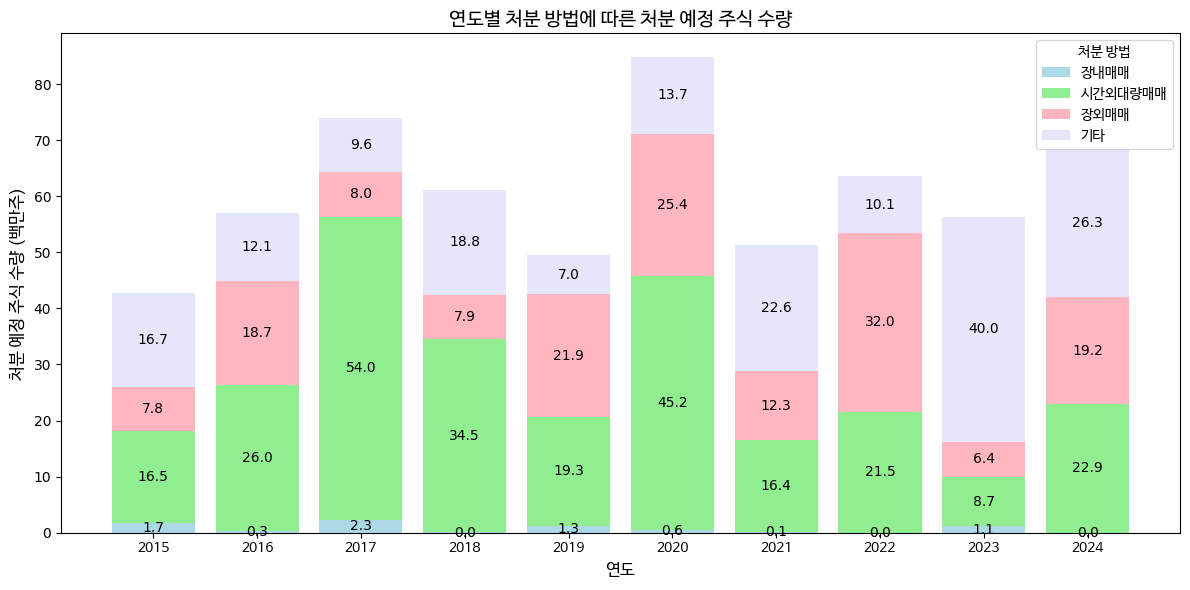

In [56]:
# 데이터를 백만 단위로 변환
df_dart_buyback_summary_millions = df_dart_buyback_summary / 1_000_000

# 1. 연도별 방법별 처분 예정 주식 스택드 바 차트
fig, ax1 = plt.subplots(figsize=(12, 6))

# 색상 설정
colors = ['lightblue', 'lightgreen', 'lightpink', 'lavender']

# 스택 초기값
bottom_stack = np.zeros(len(df_dart_buyback_summary_millions))

# 스택드 바 차트 생성
for idx, col in enumerate(df_dart_buyback_summary_millions.columns):
    bars = ax1.bar(
        df_dart_buyback_summary_millions.index,  # 연도
        df_dart_buyback_summary_millions[col],  # 데이터 값
        bottom=bottom_stack,  # 누적된 값
        label=col,  # 범례를 위한 레이블 추가
        color=colors[idx]  # 지정된 색상
    )

    # 데이터 레이블 추가
    for bar in bars:
        height = bar.get_height()
        if height > 0:  # 값이 0보다 큰 경우에만 레이블 표시
            ax1.text(bar.get_x() + bar.get_width()/2., bar.get_y() + height/2,
                     f'{height:.1f}', ha='center', va='center')

    bottom_stack += df_dart_buyback_summary_millions[col]  # 다음 스택을 위해 업데이트

# X축, Y축 및 제목 폰트 설정
ax1.set_xticks(df_dart_buyback_summary_millions.index)
ax1.set_xticklabels(df_dart_buyback_summary_millions.index, fontproperties=font, fontsize=10)
ax1.set_xlabel('연도', fontproperties=font, fontsize=12)
ax1.set_ylabel('처분 예정 주식 수량 (백만주)', fontproperties=font, fontsize=12)

# Legend 설정 (폰트 적용)
legend = ax1.legend(
    title='처분 방법',
    title_fontproperties=font,  # 제목 폰트 설정
    fontsize=10,
    prop=font  # 항목 폰트 설정
)

# 차트 제목
plt.title('연도별 처분 방법에 따른 처분 예정 주식 수량', fontproperties=font, fontsize=14)
plt.tight_layout()
plt.show()

표 형태로 숫자를 보면 아래와 같습니다.

In [62]:
# 데이터프레임 복사
df_dart_buyback_summary_show = df_dart_buyback_summary.copy()

# 대상 칼럼
columns_to_convert = ['장내매매', '시간외대량매매', '장외매매', '기타']

# 천 단위 콤마를 추가하는 함수 정의
def add_commas(x):
    return '{:,}'.format(x)

# 데이터 타입 변경
for col in columns_to_convert:
    df_dart_buyback_summary_show[col] = df_dart_buyback_summary_show[col].astype(int) # 숫자 열을 정수로 변환
    df_dart_buyback_summary_show[col] = df_dart_buyback_summary_show[col].apply(add_commas) # 함수를 데이터프레임의 숫자 열에 적용

# 결과 출력
# HTML 변환 및 커스텀 태그로 감싸기
html_table = df_dart_buyback_summary_show.reset_index().to_html(index=False, classes="dataframe", escape=False)

# 테이블을 <div> 태그로 감싸기
wrapped_html = f"""
<div class="table-container">
  {html_table}
</div>
"""
print(html_table)

df_dart_buyback_summary_show

<table border="1" class="dataframe dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>연도</th>
      <th>장내매매</th>
      <th>시간외대량매매</th>
      <th>장외매매</th>
      <th>기타</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>2015</td>
      <td>1,666,192</td>
      <td>16,530,938</td>
      <td>7,806,748</td>
      <td>16,664,682</td>
    </tr>
    <tr>
      <td>2016</td>
      <td>294,003</td>
      <td>25,968,389</td>
      <td>18,712,752</td>
      <td>12,111,177</td>
    </tr>
    <tr>
      <td>2017</td>
      <td>2,326,848</td>
      <td>54,013,232</td>
      <td>7,990,151</td>
      <td>9,580,392</td>
    </tr>
    <tr>
      <td>2018</td>
      <td>40,406</td>
      <td>34,524,186</td>
      <td>7,851,419</td>
      <td>18,768,732</td>
    </tr>
    <tr>
      <td>2019</td>
      <td>1,284,314</td>
      <td>19,285,874</td>
      <td>21,949,696</td>
      <td>6,989,774</td>
    </tr>
    <tr>
      <td>2020</td>
      <td>564,590</td>
      <td>45,215,194</td>

,장내매매,시간외대량매매,장외매매,기타
연도,,,,
2015,"1,666,192","16,530,938","7,806,748","16,664,682"
2016,"294,003","25,968,389","18,712,752","12,111,177"
2017,"2,326,848","54,013,232","7,990,151","9,580,392"
2018,"40,406","34,524,186","7,851,419","18,768,732"
2019,"1,284,314","19,285,874","21,949,696","6,989,774"
2020,"564,590","45,215,194","25,351,606","13,683,181"
2021,"126,896","16,399,457","12,301,222","22,556,112"
2022,"33,378","21,480,163","31,977,601","10,051,889"
2023,"1,137,914","8,749,493","6,362,146","39,982,108"


### 시간외대량매매의 목적
자사주 취득시에는 사용되지 않던 시간외대량매매가 자사주를 처분할 때는 상당히 많이 쓰인 것을 확인할 수 있습니다. 참고차원에서 전체 처분금액이 많은 상위 10개의 데이터를 한번 확인해 보겠습니다.<br>
금액 상위의 경우, **파트너십 구축**{: style="color: #4682B4;"}을 위한 자기주식 시간외대량매매가 많았던 것을 확인할 수 있습니다. 그리고 **자금조달을 위한 목적**{: style="color: #4682B4;"}도 2건 있습니다.

In [60]:
# 처분방법이 기타인 것이 0이 아닌 것으로 필터
df_show = df_dart_buyback[df_dart_buyback['시간외대량매매'] != 0]

# 데이터프레임 복사
df_show = df_show.sort_values(by='처분예정금액', ascending=False).head(10)

# 천 단위 콤마를 추가하는 함수 정의
def add_commas(x):
    return '{:,}'.format(x)

# 필요한 칼럼만 남기기
df_show = df_show[['회사명', '접수일', '처분예정금액', '처분예정주식','시간외대량매매',  '연도', '처분시작일', '처분종료일', '처분목적']]

# 칼럼명 수정
df_show.columns = ['회사명', '접수일', '처분예정금액(억원)', '처분예정주식', '시간외대량매매', '연도', '처분시작일', '처분종료일', '처분목적']

# 데이터 타입 변경
# 대상 칼럼
cols_to_convert = ['시간외대량매매', '처분예정주식', '처분예정금액(억원)']

# 각 칼럼에 대해 int 변환 및 add_commas 함수 적용
for col in cols_to_convert:
  df_show[col] = df_show[col].astype(int) # 정수형으로 변환
  df_show[col] = df_show[col].apply(add_commas) # add_commas 함수 적용

# 결과 출력
# HTML 변환 및 커스텀 태그로 감싸기
html_table = df_show.to_html(index=False, classes="dataframe", escape=False)

# 테이블을 <div> 태그로 감싸기
wrapped_html = f"""
<div class="table-container">
  {html_table}
</div>
"""
print(html_table)

df_show

<table border="1" class="dataframe dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>회사명</th>
      <th>접수일</th>
      <th>처분예정금액(억원)</th>
      <th>처분예정주식</th>
      <th>시간외대량매매</th>
      <th>연도</th>
      <th>처분시작일</th>
      <th>처분종료일</th>
      <th>처분목적</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>고려아연</td>
      <td>2022-11-24</td>
      <td>7,868</td>
      <td>1,195,760</td>
      <td>406,994</td>
      <td>2022</td>
      <td>2022-11-24</td>
      <td>2023년 02월 23일</td>
      <td>사업 제휴 강화를 위한 전략적 파트너십 관계 구축 및 중장기 사업계획 추진을 위한 투자자금 확보</td>
    </tr>
    <tr>
      <td>NAVER</td>
      <td>2020-10-26</td>
      <td>5,999</td>
      <td>2,094,240</td>
      <td>1,570,680</td>
      <td>2020</td>
      <td>2020-10-27</td>
      <td>2020년 11월 27일</td>
      <td>CJ 대한통운, CJ ENM, 스튜디오 드래곤과의 자사주 교환 및 현물출자를 통해 전략적 사업제휴 관계를 강화하고 유지하기 위함</td>
    </tr>
    <tr>
      <td>미래에셋증권</td>
      <td>2017-06-26</td>
      <td>4,999</td>
      <td>47,393,364</td>
      

,회사명,접수일,처분예정금액(억원),처분예정주식,시간외대량매매,연도,처분시작일,처분종료일,처분목적
52,고려아연,2022-11-24,"7,868","1,195,760","406,994",2022,2022-11-24,2023년 02월 23일,사업 제휴 강화를 위한 전략적 파트너십 관계 구축 및 중장기 사업계획 추진을 위한 ...
60,NAVER,2020-10-26,"5,999","2,094,240","1,570,680",2020,2020-10-27,2020년 11월 27일,"CJ 대한통운, CJ ENM, 스튜디오 드래곤과의 자사주 교환 및 현물출자를 통해 ..."
56,미래에셋증권,2017-06-26,"4,999","47,393,364","47,393,364",2017,2017-06-27,2017년 06월 27일,네이버(주)와의 전략적 제휴를 위한 자기주식 상호매입
59,NAVER,2017-06-26,"4,999","563,063","563,063",2017,2017-06-27,2017년 06월 27일,미래에셋대우㈜와의 전략적 제휴를 통한 글로벌 진출 및 공동사업 추진 등
5,CJ대한통운,2020-10-26,"2,999","1,791,044","1,791,044",2020,2020-10-27,2020년 10월 27일,네이버(주)와의 자사주 교환을 통한 전략적 사업제휴 관계 강화 및 유지
93,엘앤에프,2022-05-24,"2,766","1,000,000","1,000,000",2022,2022-05-24,2022년 08월 23일,해외투자자금 및 시설/운영자금의 조달
54,LG화학,2022-11-23,"2,524","367,529","367,529",2022,2022-11-24,2023년 02월 23일,2차 전지소재 사업 제휴 강화를 위한 전략적 파트너십 관계 구축
63,NAVER,2021-03-16,"2,500","648,510","648,510",2021,2021-03-17,2021년 03월 17일,온·오프라인 커머스 역량 강화를 위한 전략적 제휴
39,롯데케미칼,2017-02-21,"2,202","583,388","583,388",2017,2017-02-22,2017년 05월 19일,2012년 12월 27일 (舊)호남석유화학(주)와 (주)케이피케미칼 합병 시 케이피...
2,신풍제약,2020-09-22,"2,153","1,289,550","1,289,550",2020,2020-09-22,2020년 09월 22일,생산설비 개선 및 연구개발과제 투자 자금 확보


## 코스닥 자기주식 **직접 처분** 통계 불러오기
이번에는 코스닥시장의 자기주식 직접처분 통계를 보겠습니다. 코스닥 시장의 자기주식 처분 포스팅은 따로 한적이 없으므로 그 과정을 좀 더 설명하겠습니다.

In [65]:
# 데이터 검색기준 설정하기
start_y = "2015"
end_y = "2024"
corp_type = "A" #유가는 "P", 코스닥은 "A", 유가및코스닥은 ["P", "A"] 입력
reportCode = "11333" #직접취득 11332, 직접처분 11333, 신탁취득 11334, 신탁해지 11335

# 기본 params 템플릿
params = {
    "pageIndex": "1",
    "pageSize": "10",
    "pageUnit": "10",
    "recordCountPerPage": "1000",
    "sortStdr": "crp",
    "sortOrdr": "asc",
    "sumSortStdr": "",
    "sumSortOrdr": "asc",
    "textCrpCik": "",
    "bgnDe": f"{start_y}-01-01",
    "endDe": f"{end_y}-12-31",
    "textCrpNm": "",
    "startDate": f"{start_y}-01-01",
    "endDate": f"{end_y}-12-31",
    "reportCode": f"{reportCode}",
    "corpType" : f"{corp_type}"
}

# 결과 출력
params

{'pageIndex': '1',
 'pageSize': '10',
 'pageUnit': '10',
 'recordCountPerPage': '1000',
 'sortStdr': 'crp',
 'sortOrdr': 'asc',
 'sumSortStdr': '',
 'sumSortOrdr': 'asc',
 'textCrpCik': '',
 'bgnDe': '2015-01-01',
 'endDe': '2024-12-31',
 'textCrpNm': '',
 'startDate': '2015-01-01',
 'endDate': '2024-12-31',
 'reportCode': '11333',
 'corpType': 'A'}

In [66]:
# 첫번째 페이지를 기준으로 크롤링
url = 'https://opendart.fss.or.kr/disclosureinfo/mainMatter/list.do'
req = requests.post(url, params = params)
content = req.content.decode('utf-8')

# beautifulsoup 객체로 전환
soup = BeautifulSoup(content, 'html.parser')

# 끝에서 두번째 div 태그에 페이지 정보가 있음
output_string = soup.find_all('div')[-2].text

import re

# 정규 표현식을 사용하여 숫자 추출
# 백만단위 건수는 아닐거라는 가정임. 즉, 콤마가 많아도 하나만 있다는 가정임
match = re.match(r"\[(\d+)/(\d+)\] \[총 (\d+)?,?(\d+)건\]", output_string)

if match:
    total_page = int(match.group(2))
    total_counts_before_comma = match.group(3)
    total_counts_after_comma = match.group(4)
    print(f"total_page: {total_page}")
    print(f"total_counts: {total_counts_before_comma},{total_counts_after_comma}")
else:
    print("출력물 형식이 올바르지 않습니다.")

total_page: 20
total_counts: 1,911


In [67]:
# 데이터를 수집할 빈 데이터프레임(마스터 데이터프레임) 생성
df_dart_buyback = pd.DataFrame()

# 이미 받아놓은 값(content)에서 첫번째 페이지의 데이터프레임 파싱
html_string = StringIO(content)  # StringIO로 HTML 문자열 감싸기
df_loop = pd.read_html(html_string)[0]

# 마스터 데이터프레임에 합치기
df_dart_buyback = pd.concat([df_dart_buyback, df_loop])

for i in range(2, total_page + 1):
  page_index = str(i)
  # params 기준에서 페이지 인덱스만 수정하기
  params["pageIndex"] = page_index

  req = requests.post(url, params = params)
  content = req.content.decode('utf-8')
  html_string = StringIO(content)  # StringIO로 HTML 문자열 감싸기
  df_loop = pd.read_html(html_string)[0]

  # IP차단을 위해 쉬어가기
  sleep(1)

  # 마스터 데이터프레임에 합치기
  df_dart_buyback = pd.concat([df_dart_buyback, df_loop])

In [68]:
# 확인된 값을 바탕으로 칼럼명을 지정
df_dart_buyback.columns = ['회사명', '접수일',
                           '처분예정주식(주)_보통주식', '처분예정주식(주)_기타주식',
                           '처분 대상 주식가격(원)_보통주식', '처분 대상 주식가격(원)_기타주식',
                           '처분예정금액(원)_보통주식', '처분예정금액(원)_기타주식',
                           '처분예상기간_시작일','처분예상기간_종료일',
                           '처분목적',
                           '처분방법_시장을 통한 매도(주)',
                           '처분방법_시간외대량매매(주)',
                           '처분방법_장외처분(주)',
                           '처분방법_기타(주)',
                           '위탁투자중개업자',
                           '처분 전 자기주식 보유현황_배당가능이익 범위 내 처분(주)_보통주식',
                           '처분 전 자기주식 보유현황_배당가능이익 범위 내 처분(주)_비율(%)',
                           '처분 전 자기주식 보유현황_배당가능이익 범위 내 처분(주)_기타주식',
                           '처분 전 자기주식 보유현황_배당가능이익 범위 내 처분(주)_비율(%).1',
                           '처분 전 자기주식 보유현황_기타처분(주)_보통주식',
                           '처분 전 자기주식 보유현황_기타처분(주)_비율(%)',
                           '처분 전 자기주식 보유현황_기타처분(주)_기타주식',
                           '처분 전 자기주식 보유현황_기타처분(주)_비율(%).1',
                           '처분결정일',
                           '사외이사참석여부_참석(명)', '사외이사참석여부_불참(명)',
                           '감사 (사외이사가 아닌 감사위원) 참석여부',
                           '1일 매도 주문수량 한도_보통주식', '1일 매도 주문수량 한도_기타주식',
                           '비고']

In [69]:
# 필요한 칼럼만 선택하고 이름을 변경하여 새로운 데이터프레임 생성
df_dart_buyback = df_dart_buyback[['회사명', '접수일',
                           '처분예정주식(주)_보통주식',
                           '처분예정금액(원)_보통주식',
                           '처분예상기간_시작일','처분예상기간_종료일',
                           '처분목적',
                           '처분방법_시장을 통한 매도(주)',
                           '처분방법_시간외대량매매(주)',
                           '처분방법_장외처분(주)',
                           '처분방법_기타(주)']].copy()

df_dart_buyback.columns = ['회사명', '접수일',
                           '처분예정주식','처분예정금액','처분시작일','처분종료일',
                           '처분목적', '장내매매', '시간외대량매매', '장외매매', '기타']

# 기존에는 접수일을 datetime으로 변환 및 연도 추출하였으나,
# 공시가 정정될 경우, 연도가 바뀌는 이슈가 있었음
# 그리하여 연도의 기준은 '처분예상기간의 시작일'로 설정함

#다트 편집기를 보면 날짜를 입력하는 형태는 두가지가 있다
#(1) 2022.08.03
#(2) 2022년 08월 03일
#따라서 두번째 형태일 경우 첫번째 형태로 전환하는 함수를 생성한다
def chg_date_format(date_input) :
    if '년' in date_input:
        new_year = date_input[0:4]
        new_month = date_input[6:8]
        new_day = date_input[10:12]
        new_date = new_year + new_month + new_day
    else :
        new_date = date_input
    return new_date

#생성한 함수를 통해서 포맷을 바꿔준다
df_dart_buyback['처분시작일'] = df_dart_buyback.처분시작일.apply(lambda x : chg_date_format(x))
df_dart_buyback['처분시작일'] = pd.to_datetime(df_dart_buyback['처분시작일'], errors='coerce')
df_dart_buyback['연도'] = df_dart_buyback['처분시작일'].dt.year

# 데이터 타입 변경
df_dart_buyback['연도'] = pd.to_numeric(df_dart_buyback['연도'], errors='coerce').astype('Int64')

df_dart_buyback['처분예정주식'] = pd.to_numeric(
    df_dart_buyback['처분예정주식'], errors='coerce').fillna(0)

df_dart_buyback['처분예정금액'] = pd.to_numeric(
    df_dart_buyback['처분예정금액'], errors='coerce').fillna(0) / 1e8  # 원 -> 억 원 변환

# 맨 앞의 '유' 또는 '코' 제거, 맨 끝의 'IR' 제거
df_dart_buyback['회사명'] = df_dart_buyback['회사명'].str.replace(r'^(유|코)', '', regex=True).str.replace(r'  IR$', '', regex=True).str.replace(r'IR$', '', regex=True)


### 자사주 직접처분 데이터 시각화
 코스피 시장과 마찬가지 절차로 데이터를 불러오고 시각화를 바로 실행하겠습니다.

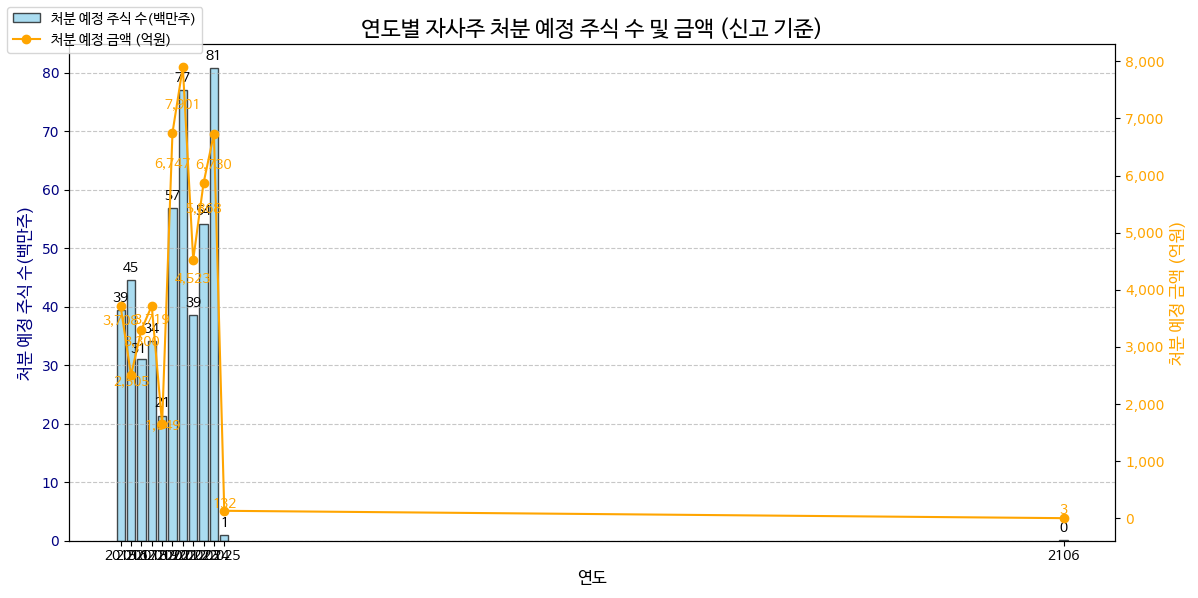

In [70]:
# 연도별 처분예정주식(주) 및 처분예정금액 집계
annual_summary = df_dart_buyback.groupby('연도').agg({
    '처분예정주식': 'sum',
    '처분예정금액': 'sum'
})

# 단위 변환
annual_summary['처분예정주식'] = annual_summary['처분예정주식'] / 1000000 # 주 -> 백만주 변환

# 그래프 크기 설정
fig, ax1 = plt.subplots(figsize=(12, 6))

# 막대 그래프: 연도별 처분 예정 주식 수
bars = ax1.bar(annual_summary.index,
               annual_summary['처분예정주식'],
               color='skyblue', edgecolor='black', alpha=0.7, label='처분 예정 주식 수(백만주)')
ax1.set_xlabel('연도', fontproperties=font, fontsize=12)
ax1.set_ylabel('처분 예정 주식 수(백만주)', fontproperties=font, fontsize=12, color='navy')
ax1.tick_params(axis='y', labelcolor='navy')

# x축 눈금 설정 (모든 연도 표시)
plt.xticks(annual_summary.index, fontproperties=font, fontsize=10)

# 데이터 라벨 추가 (막대 그래프)
texts = []
for bar in bars:
    height = bar.get_height()
    if height > 0:  # 데이터가 있는 경우에만 레이블 추가
        texts.append(ax1.text(bar.get_x() + bar.get_width() / 2., height,
                              f'{height:,.0f}', ha='center', va='bottom',
                              fontproperties=font, fontsize=10))

# 보조축 추가: 처분 예정 금액
ax2 = ax1.twinx()
line, = ax2.plot(annual_summary.index,
                 annual_summary['처분예정금액'],
                 color='orange', marker='o', label='처분 예정 금액 (억원)')
ax2.set_ylabel('처분 예정 금액 (억원)', fontproperties=font, fontsize=12, color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# y축 보조축에 천 단위 콤마 추가
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

# 선 그래프 레이블 추가
for i, value in enumerate(annual_summary['처분예정금액']):
    ax2.text(annual_summary.index[i], value*0.9, f'{value:,.0f}',
             color='orange', fontsize=10, ha='center', va='bottom', fontproperties=font)

# adjustText를 사용하여 레이블 위치 조정
adjust_text(texts, ax=ax1)

# y축 그리드 추가
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# 범례 추가
fig.legend(loc='upper left', bbox_transform=ax1.transAxes, prop=font)

# 그래프 제목 설정
plt.title('연도별 자사주 처분 예정 주식 수 및 금액 (신고 기준)', fontproperties=font, fontsize=16)

# 그래프 여백 조정
plt.tight_layout()

# 그래프 표시
plt.show()


헉... 처분시점을 무려 2106년으로 기재한 경우가 보입니다. 어느 회사일까요?

In [71]:
# 그림이 이상하게 나와서 아웃라이어를 확인
df_show = df_dart_buyback[df_dart_buyback['연도'] == 2106]

# 결과 출력
# HTML 변환 및 커스텀 태그로 감싸기
html_table = df_show.to_html(index=False, classes="dataframe", escape=False)

# 테이블을 <div> 태그로 감싸기
wrapped_html = f"""
<div class="table-container">
  {html_table}
</div>
"""
print(html_table)

df_show

<table border="1" class="dataframe dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>회사명</th>
      <th>접수일</th>
      <th>처분예정주식</th>
      <th>처분예정금액</th>
      <th>처분시작일</th>
      <th>처분종료일</th>
      <th>처분목적</th>
      <th>장내매매</th>
      <th>시간외대량매매</th>
      <th>장외매매</th>
      <th>기타</th>
      <th>연도</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>알티캐스트</td>
      <td>2016-01-08</td>
      <td>58772.0</td>
      <td>2.915091</td>
      <td>2106-01-08</td>
      <td>2016년 01월 21일</td>
      <td>2014년 약정분 주식보상성과급 지급(2014년 직원 성과급 중 주식보상분을 자기주식으로 지급)</td>
      <td>-</td>
      <td>-</td>
      <td>-</td>
      <td>58772</td>
      <td>2106</td>
    </tr>
  </tbody>
</table>


,회사명,접수일,처분예정주식,처분예정금액,처분시작일,처분종료일,처분목적,장내매매,시간외대량매매,장외매매,기타,연도
41,알티캐스트,2016-01-08,58772.0,2.915091,2106-01-08,2016년 01월 21일,2014년 약정분 주식보상성과급 지급(2014년 직원 성과급 중 주식보상분을 자기주...,-,-,-,58772,2106


알티캐스트입니다. 2016을 오타낸 것으로 추정이 가능하므로 수정해주도록 하겠습니다.

In [72]:
# 조건에 맞는 행의 특정 칼럼 값을 수정
#우선 접수일의 형태를 날짜로 변경
df_dart_buyback['접수일'] = pd.to_datetime(df_dart_buyback['접수일'])

df_dart_buyback.loc[
    (df_dart_buyback['회사명'] == "알티캐스트") &
    (df_dart_buyback['접수일'] == datetime(2016, 1, 8)),
    '처분시작일'
] = datetime(2016, 1, 8)

# 수정된 처분시작을을 바탕으로 연도 칼럼 업데이트
df_dart_buyback['연도'] = df_dart_buyback['처분시작일'].dt.year.astype('Int64')

# 잘반영되었는지 확인
df_show = df_dart_buyback[
    (df_dart_buyback['회사명'] == "알티캐스트") &
    (df_dart_buyback['접수일'] == datetime(2016, 1, 8))
]

# 결과 출력
# HTML 변환 및 커스텀 태그로 감싸기
html_table = df_show.to_html(index=False, classes="dataframe", escape=False)

# 테이블을 <div> 태그로 감싸기
wrapped_html = f"""
<div class="table-container">
  {html_table}
</div>
"""
print(html_table)

df_show

<table border="1" class="dataframe dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>회사명</th>
      <th>접수일</th>
      <th>처분예정주식</th>
      <th>처분예정금액</th>
      <th>처분시작일</th>
      <th>처분종료일</th>
      <th>처분목적</th>
      <th>장내매매</th>
      <th>시간외대량매매</th>
      <th>장외매매</th>
      <th>기타</th>
      <th>연도</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>알티캐스트</td>
      <td>2016-01-08</td>
      <td>58772.0</td>
      <td>2.915091</td>
      <td>2016-01-08</td>
      <td>2016년 01월 21일</td>
      <td>2014년 약정분 주식보상성과급 지급(2014년 직원 성과급 중 주식보상분을 자기주식으로 지급)</td>
      <td>-</td>
      <td>-</td>
      <td>-</td>
      <td>58772</td>
      <td>2016</td>
    </tr>
  </tbody>
</table>


,회사명,접수일,처분예정주식,처분예정금액,처분시작일,처분종료일,처분목적,장내매매,시간외대량매매,장외매매,기타,연도
41,알티캐스트,2016-01-08,58772.0,2.915091,2016-01-08,2016년 01월 21일,2014년 약정분 주식보상성과급 지급(2014년 직원 성과급 중 주식보상분을 자기주...,-,-,-,58772,2016


오타를 수정했으니 다시 그래프를 확인해보겠습니다.

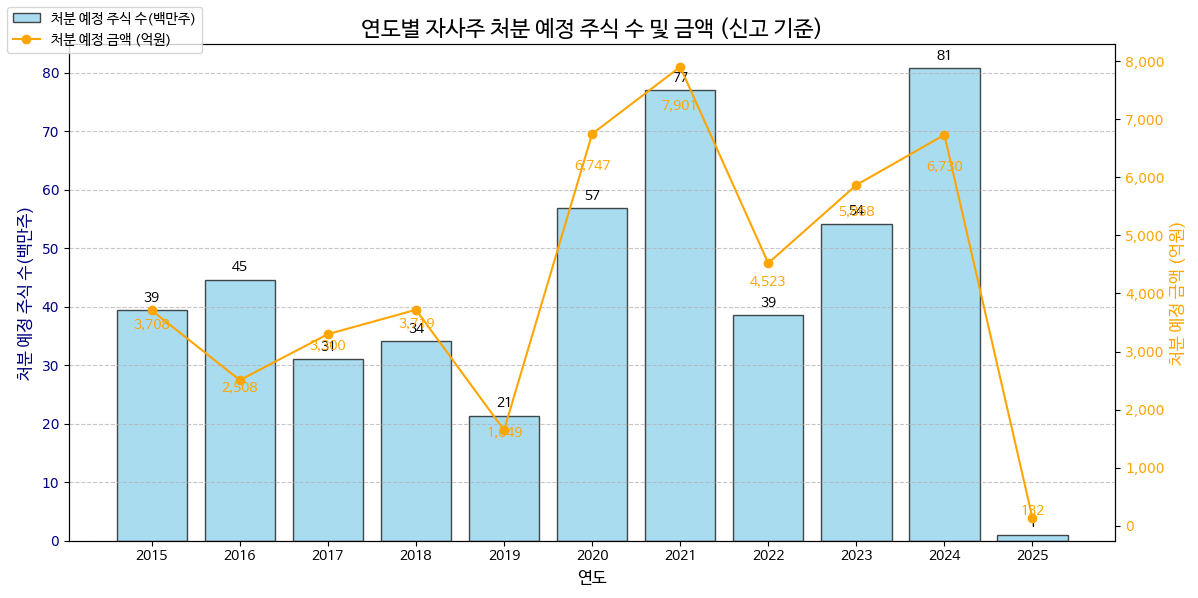

In [73]:


# 연도별 처분예정주식(주) 및 처분예정금액 집계
annual_summary = df_dart_buyback.groupby('연도').agg({
    '처분예정주식': 'sum',
    '처분예정금액': 'sum'
})

# 단위 변환
annual_summary['처분예정주식'] = annual_summary['처분예정주식'] / 1000000 # 주 -> 백만주 변환

# 그래프 크기 설정
fig, ax1 = plt.subplots(figsize=(12, 6))

# 막대 그래프: 연도별 처분 예정 주식 수
bars = ax1.bar(annual_summary.index,
               annual_summary['처분예정주식'],
               color='skyblue', edgecolor='black', alpha=0.7, label='처분 예정 주식 수(백만주)')
ax1.set_xlabel('연도', fontproperties=font, fontsize=12)
ax1.set_ylabel('처분 예정 주식 수(백만주)', fontproperties=font, fontsize=12, color='navy')
ax1.tick_params(axis='y', labelcolor='navy')

# x축 눈금 설정 (모든 연도 표시)
plt.xticks(annual_summary.index, fontproperties=font, fontsize=10)

# 데이터 라벨 추가 (막대 그래프)
texts = []
for bar in bars:
    height = bar.get_height()
    if height > 0:  # 데이터가 있는 경우에만 레이블 추가
        texts.append(ax1.text(bar.get_x() + bar.get_width() / 2., height,
                              f'{height:,.0f}', ha='center', va='bottom',
                              fontproperties=font, fontsize=10))

# 보조축 추가: 처분 예정 금액
ax2 = ax1.twinx()
line, = ax2.plot(annual_summary.index,
                 annual_summary['처분예정금액'],
                 color='orange', marker='o', label='처분 예정 금액 (억원)')
ax2.set_ylabel('처분 예정 금액 (억원)', fontproperties=font, fontsize=12, color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# y축 보조축에 천 단위 콤마 추가
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

# 선 그래프 레이블 추가
for i, value in enumerate(annual_summary['처분예정금액']):
    ax2.text(annual_summary.index[i], value*0.9, f'{value:,.0f}',
             color='orange', fontsize=10, ha='center', va='bottom', fontproperties=font)

# adjustText를 사용하여 레이블 위치 조정
adjust_text(texts, ax=ax1)

# y축 그리드 추가
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# 범례 추가
fig.legend(loc='upper left', bbox_transform=ax1.transAxes, prop=font)

# 그래프 제목 설정
plt.title('연도별 자사주 처분 예정 주식 수 및 금액 (신고 기준)', fontproperties=font, fontsize=16)

# 그래프 여백 조정
plt.tight_layout()

# 그래프 표시
plt.show()


그래프의 이 모습을 기억해놓아야 합니다. 앞으로 처분방식별로 구분한 그래프를 그렸을 때 그 합계가 지금의 그래프와 모양이 다르다면 다른 오타가 존재한다는 것입니다.

In [74]:
# 데이터 타입 변경
columns_to_convert = ['장내매매', '시간외대량매매', '장외매매', '기타']

for col in columns_to_convert:
    df_dart_buyback[col] = pd.to_numeric(df_dart_buyback[col], errors='coerce').fillna(0)

# 연도별 방법별 처분예정주식(주) 집계
df_dart_buyback_summary = df_dart_buyback.groupby('연도').agg({
    '장내매매': 'sum',
    '시간외대량매매': 'sum',
    '장외매매': 'sum',
    '기타': 'sum'
})

### 공시에서 발견된 오타들!
시각화를 해서 보던 중, 아래와 같은 그림이 그려졌습니다.

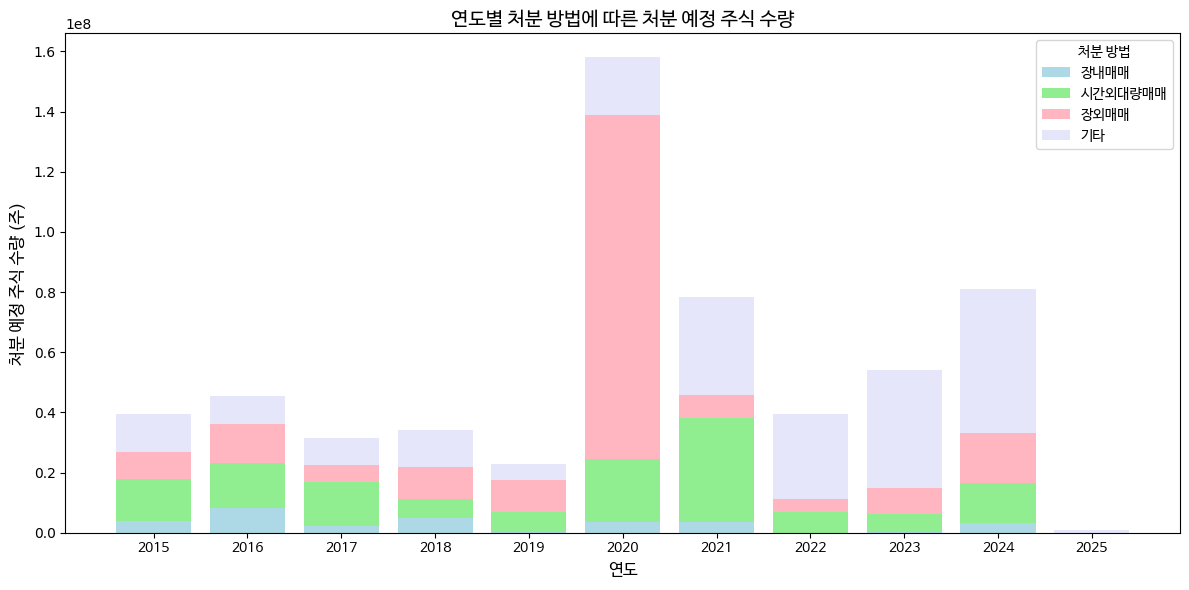

In [75]:
# 1. 연도별 방법별 처분 예정 주식 스택드 바 차트
fig, ax1 = plt.subplots(figsize=(12, 6))

# 색상 설정
colors = ['lightblue', 'lightgreen', 'lightpink', 'lavender']
# 사용 가능한 색상: lightblue, lightpink, lightgreen, lavender, peachpuff, powderblue, palegoldenrod, thistle, honeydew, mistyrose

# 스택 초기값
bottom_stack = np.zeros(len(df_dart_buyback_summary))

# 스택드 바 차트 생성
for idx, col in enumerate(df_dart_buyback_summary.columns):
    ax1.bar(
        df_dart_buyback_summary.index,  # 연도
        df_dart_buyback_summary[col],  # 데이터 값
        bottom=bottom_stack,  # 누적된 값
        label=col,  # 범례를 위한 레이블 추가
        color=colors[idx]  # 지정된 색상
    )
    bottom_stack += df_dart_buyback_summary[col]  # 다음 스택을 위해 업데이트

# X축, Y축 및 제목 폰트 설정
ax1.set_xticks(df_dart_buyback_summary.index)
ax1.set_xticklabels(df_dart_buyback_summary.index, fontproperties=font, fontsize=10)
ax1.set_xlabel('연도', fontproperties=font, fontsize=12)
ax1.set_ylabel('처분 예정 주식 수량 (주)', fontproperties=font, fontsize=12)

# Legend 설정 (폰트 적용)
legend = ax1.legend(
    title='처분 방법',
    title_fontproperties=font,  # 제목 폰트 설정
    fontsize=10,
    prop=font  # 항목 폰트 설정
)

# 차트 제목
plt.title('연도별 처분 방법에 따른 처분 예정 주식 수량', fontproperties=font, fontsize=14)
plt.tight_layout()
plt.show()

그래프가 앞서 그렸던 것과 다릅니다. 그래프의 모양은 동일하고 그 안에서만 색깔이 달라야 하는데, 이렇게 형태 자체가 달라져버린 것은 왜일까요? 처분방식별 수량을 입력하는 과정에서 오타가 난 것이라고 추정해볼 수 있습니다. 일단 2020년의 장외매매 수량이 상당히 높은 수치를 나타내고 있으니 이걸 확인해보겠습니다. <br>

따라서 아래와 같이 필터를 적용해서 데이터를 직접 확인해보겠습니다. 2021년 데이터 중, 처분방법이 기타인 것을 기준으로 내림차순으로 정리해 봅니다.


In [76]:
# 그림이 이상하게 나와서 아웃라이어를 확인
df_show = df_dart_buyback[df_dart_buyback['연도'] == 2020]

# 데이터프레임 복사
df_show = df_show.sort_values(by='장외매매', ascending=False).head()

# 대상 칼럼
columns_to_convert = ['장내매매', '시간외대량매매', '장외매매', '기타']

# 천 단위 콤마를 추가하는 함수 정의
def add_commas(x):
    return '{:,}'.format(x)

# 데이터 타입 변경
for col in columns_to_convert:
    df_show[col] = df_show[col].astype(int) # 숫자 열을 정수로 변환
    df_show[col] = df_show[col].apply(add_commas) # 함수를 데이터프레임의 숫자 열에 적용

# 결과 출력
# HTML 변환 및 커스텀 태그로 감싸기
html_table = df_show.to_html(index=False, classes="dataframe", escape=False)

# 테이블을 <div> 태그로 감싸기
wrapped_html = f"""
<div class="table-container">
  {html_table}
</div>
"""
print(html_table)

df_show

<table border="1" class="dataframe dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>회사명</th>
      <th>접수일</th>
      <th>처분예정주식</th>
      <th>처분예정금액</th>
      <th>처분시작일</th>
      <th>처분종료일</th>
      <th>처분목적</th>
      <th>장내매매</th>
      <th>시간외대량매매</th>
      <th>장외매매</th>
      <th>기타</th>
      <th>연도</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>유아이디</td>
      <td>2020-07-02</td>
      <td>94787.0</td>
      <td>1.000003</td>
      <td>2020-07-03</td>
      <td>2020년 10월 02일</td>
      <td>운영자금 확보</td>
      <td>0</td>
      <td>0</td>
      <td>100,000,285</td>
      <td>0</td>
      <td>2020</td>
    </tr>
    <tr>
      <td>한성크린텍</td>
      <td>2020-12-15</td>
      <td>9243937.0</td>
      <td>52.320683</td>
      <td>2020-12-16</td>
      <td>2020년 12월 31일</td>
      <td>운영자금 및 투자자금 확보</td>
      <td>0</td>
      <td>0</td>
      <td>9,243,937</td>
      <td>0</td>
      <td>2020</td>
    </tr>
    <tr>
      <td>동일스틸럭스</td>
      <td>2020-12

,회사명,접수일,처분예정주식,처분예정금액,처분시작일,처분종료일,처분목적,장내매매,시간외대량매매,장외매매,기타,연도
93,유아이디,2020-07-02,94787.0,1.000003,2020-07-03,2020년 10월 02일,운영자금 확보,0,0,"100,000,285",0,2020
36,한성크린텍,2020-12-15,9243937.0,52.320683,2020-12-16,2020년 12월 31일,운영자금 및 투자자금 확보,0,0,"9,243,937",0,2020
49,동일스틸럭스,2020-12-15,1000000.0,55.800000,2020-12-16,2020년 12월 16일,유통주식수 확대 및 거래활성화,0,0,"1,000,000",0,2020
67,하이즈항공,2020-12-14,900000.0,49.320000,2020-12-14,2020년 12월 14일,투자재원 확보,0,0,"900,000",0,2020
86,디엔에프,2020-06-15,600000.0,79.200000,2020-06-16,2020년 07월 01일,사업 다각화 및 경쟁력 강화를 위한 피인수회사 주식 취득 목적의 당사 자기주식 교환,0,0,"600,000",0,2020


2020.7.2에 제출된 유아이디의 공시에 오타가 있음을 알 수 있습니다. 전체 처분예정 주식수를 94,787주라고 기재하고선, 장외매매 수량을 100,000,285주라고 하였네요. 100,000,285는 처분예정금액을 나타내는 수치입니다. 코스피시장의 카카오, TP와 동일한 실수를 저질렀습니다. 숫자를 수정해주도록 하겠습니다.

In [77]:
# 조건에 맞는 행의 특정 칼럼 값을 수정
#우선 접수일의 형태를 날짜로 변경
df_dart_buyback['접수일'] = pd.to_datetime(df_dart_buyback['접수일'])

df_dart_buyback.loc[
    (df_dart_buyback['회사명'] == "유아이디") &
    (df_dart_buyback['접수일'] == datetime(2020, 7, 2)),
    '장외매매'
] = 94787

# 잘반영되었는지 확인
df_show = df_dart_buyback[
    (df_dart_buyback['회사명'] == "유아이디") &
    (df_dart_buyback['접수일'] == datetime(2020, 7, 2))
]

# 결과 출력
# HTML 변환 및 커스텀 태그로 감싸기
html_table = df_show.to_html(index=False, classes="dataframe", escape=False)

# 테이블을 <div> 태그로 감싸기
wrapped_html = f"""
<div class="table-container">
  {html_table}
</div>
"""
print(html_table)

df_show

<table border="1" class="dataframe dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>회사명</th>
      <th>접수일</th>
      <th>처분예정주식</th>
      <th>처분예정금액</th>
      <th>처분시작일</th>
      <th>처분종료일</th>
      <th>처분목적</th>
      <th>장내매매</th>
      <th>시간외대량매매</th>
      <th>장외매매</th>
      <th>기타</th>
      <th>연도</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>유아이디</td>
      <td>2020-07-02</td>
      <td>94787.0</td>
      <td>1.000003</td>
      <td>2020-07-03</td>
      <td>2020년 10월 02일</td>
      <td>운영자금 확보</td>
      <td>0.0</td>
      <td>0.0</td>
      <td>94787.0</td>
      <td>0.0</td>
      <td>2020</td>
    </tr>
  </tbody>
</table>


,회사명,접수일,처분예정주식,처분예정금액,처분시작일,처분종료일,처분목적,장내매매,시간외대량매매,장외매매,기타,연도
93,유아이디,2020-07-02,94787.0,1.000003,2020-07-03,2020년 10월 02일,운영자금 확보,0.0,0.0,94787.0,0.0,2020


### 처분방법별 자사주 처분 시각화
잘 반영된 것 같으니, 이제 다시 시각화를 실행해 보겠습니다.

In [78]:
# 데이터 타입 변경
columns_to_convert = ['장내매매', '시간외대량매매', '장외매매', '기타']

for col in columns_to_convert:
    df_dart_buyback[col] = pd.to_numeric(df_dart_buyback[col], errors='coerce').fillna(0)

# 연도별 방법별 처분예정주식(주) 집계
df_dart_buyback_summary = df_dart_buyback.groupby('연도').agg({
    '장내매매': 'sum',
    '시간외대량매매': 'sum',
    '장외매매': 'sum',
    '기타': 'sum'
})

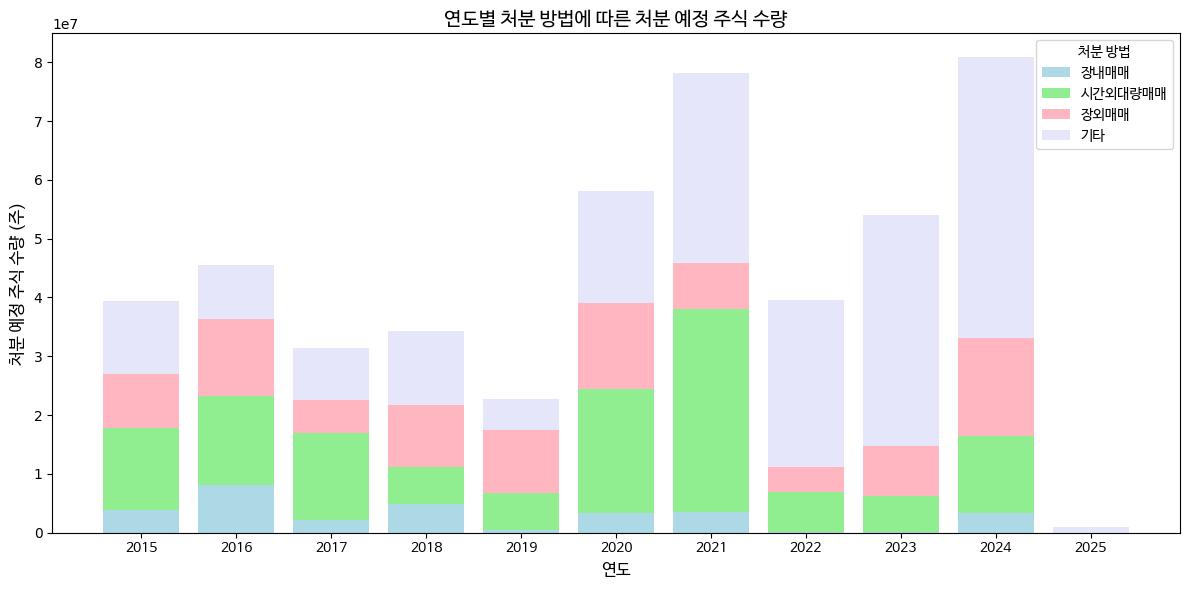

In [79]:
# 1. 연도별 방법별 처분 예정 주식 스택드 바 차트
fig, ax1 = plt.subplots(figsize=(12, 6))

# 색상 설정
colors = ['lightblue', 'lightgreen', 'lightpink', 'lavender']
# 사용 가능한 색상: lightblue, lightpink, lightgreen, lavender, peachpuff, powderblue, palegoldenrod, thistle, honeydew, mistyrose

# 스택 초기값
bottom_stack = np.zeros(len(df_dart_buyback_summary))

# 스택드 바 차트 생성
for idx, col in enumerate(df_dart_buyback_summary.columns):
    ax1.bar(
        df_dart_buyback_summary.index,  # 연도
        df_dart_buyback_summary[col],  # 데이터 값
        bottom=bottom_stack,  # 누적된 값
        label=col,  # 범례를 위한 레이블 추가
        color=colors[idx]  # 지정된 색상
    )
    bottom_stack += df_dart_buyback_summary[col]  # 다음 스택을 위해 업데이트

# X축, Y축 및 제목 폰트 설정
ax1.set_xticks(df_dart_buyback_summary.index)
ax1.set_xticklabels(df_dart_buyback_summary.index, fontproperties=font, fontsize=10)
ax1.set_xlabel('연도', fontproperties=font, fontsize=12)
ax1.set_ylabel('처분 예정 주식 수량 (주)', fontproperties=font, fontsize=12)

# Legend 설정 (폰트 적용)
legend = ax1.legend(
    title='처분 방법',
    title_fontproperties=font,  # 제목 폰트 설정
    fontsize=10,
    prop=font  # 항목 폰트 설정
)

# 차트 제목
plt.title('연도별 처분 방법에 따른 처분 예정 주식 수량', fontproperties=font, fontsize=14)
plt.tight_layout()
plt.show()

![comparison]({{site.url}}/assets/images/2025-02-16-blockdeal/comparison.png)<br><br>

오! 이전에 그렸던 그림과 비교하니 이제 맞는 바차트가 나왔습니다. 데이터레이블을 추가해 보겠습니다.

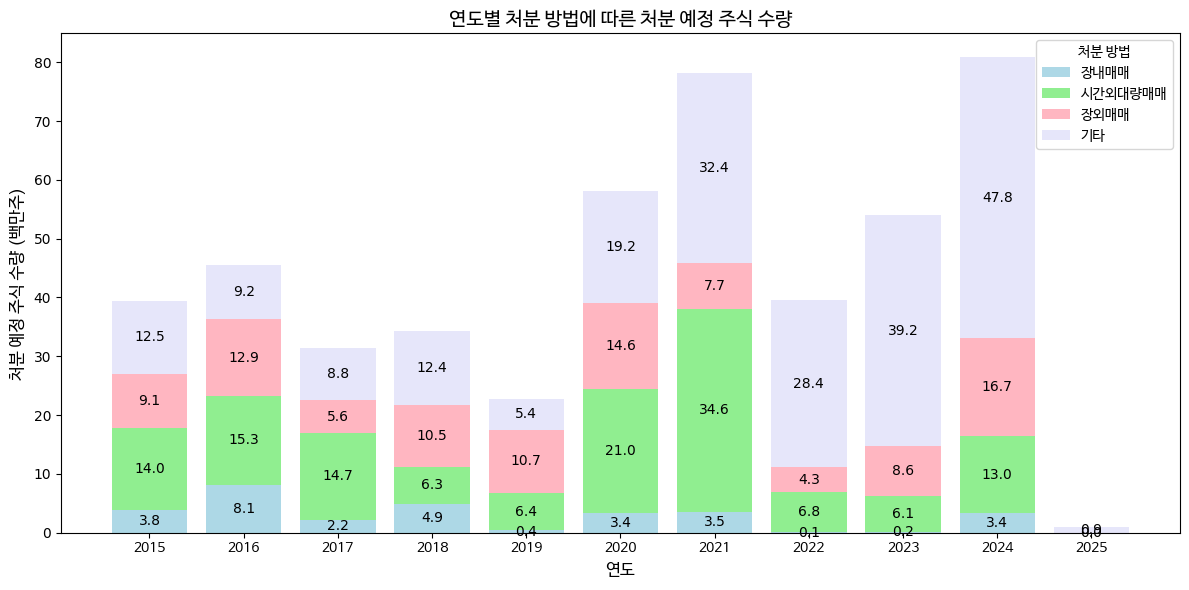

In [80]:
# 데이터를 백만 단위로 변환
df_dart_buyback_summary_millions = df_dart_buyback_summary / 1_000_000

# 1. 연도별 방법별 처분 예정 주식 스택드 바 차트
fig, ax1 = plt.subplots(figsize=(12, 6))

# 색상 설정
colors = ['lightblue', 'lightgreen', 'lightpink', 'lavender']

# 스택 초기값
bottom_stack = np.zeros(len(df_dart_buyback_summary_millions))

# 스택드 바 차트 생성
for idx, col in enumerate(df_dart_buyback_summary_millions.columns):
    bars = ax1.bar(
        df_dart_buyback_summary_millions.index,  # 연도
        df_dart_buyback_summary_millions[col],  # 데이터 값
        bottom=bottom_stack,  # 누적된 값
        label=col,  # 범례를 위한 레이블 추가
        color=colors[idx]  # 지정된 색상
    )

    # 데이터 레이블 추가
    for bar in bars:
        height = bar.get_height()
        if height > 0:  # 값이 0보다 큰 경우에만 레이블 표시
            ax1.text(bar.get_x() + bar.get_width()/2., bar.get_y() + height/2,
                     f'{height:.1f}', ha='center', va='center')

    bottom_stack += df_dart_buyback_summary_millions[col]  # 다음 스택을 위해 업데이트

# X축, Y축 및 제목 폰트 설정
ax1.set_xticks(df_dart_buyback_summary_millions.index)
ax1.set_xticklabels(df_dart_buyback_summary_millions.index, fontproperties=font, fontsize=10)
ax1.set_xlabel('연도', fontproperties=font, fontsize=12)
ax1.set_ylabel('처분 예정 주식 수량 (백만주)', fontproperties=font, fontsize=12)

# Legend 설정 (폰트 적용)
legend = ax1.legend(
    title='처분 방법',
    title_fontproperties=font,  # 제목 폰트 설정
    fontsize=10,
    prop=font  # 항목 폰트 설정
)

# 차트 제목
plt.title('연도별 처분 방법에 따른 처분 예정 주식 수량', fontproperties=font, fontsize=14)
plt.tight_layout()
plt.show()

In [81]:
# 데이터프레임 복사
df_dart_buyback_summary_show = df_dart_buyback_summary.copy()

# 대상 칼럼
columns_to_convert = ['장내매매', '시간외대량매매', '장외매매', '기타']

# 천 단위 콤마를 추가하는 함수 정의
def add_commas(x):
    return '{:,}'.format(x)

# 데이터 타입 변경
for col in columns_to_convert:
    df_dart_buyback_summary_show[col] = df_dart_buyback_summary_show[col].astype(int) # 숫자 열을 정수로 변환
    df_dart_buyback_summary_show[col] = df_dart_buyback_summary_show[col].apply(add_commas) # 함수를 데이터프레임의 숫자 열에 적용

# 결과 출력
# HTML 변환 및 커스텀 태그로 감싸기
html_table = df_dart_buyback_summary_show.reset_index().to_html(index=False, classes="dataframe", escape=False)

# 테이블을 <div> 태그로 감싸기
wrapped_html = f"""
<div class="table-container">
  {html_table}
</div>
"""
print(html_table)

df_dart_buyback_summary_show

<table border="1" class="dataframe dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>연도</th>
      <th>장내매매</th>
      <th>시간외대량매매</th>
      <th>장외매매</th>
      <th>기타</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>2015</td>
      <td>3,823,928</td>
      <td>13,963,064</td>
      <td>9,141,530</td>
      <td>12,542,702</td>
    </tr>
    <tr>
      <td>2016</td>
      <td>8,063,229</td>
      <td>15,264,438</td>
      <td>12,933,541</td>
      <td>9,209,855</td>
    </tr>
    <tr>
      <td>2017</td>
      <td>2,247,160</td>
      <td>14,735,479</td>
      <td>5,559,840</td>
      <td>8,830,739</td>
    </tr>
    <tr>
      <td>2018</td>
      <td>4,901,213</td>
      <td>6,340,944</td>
      <td>10,539,369</td>
      <td>12,446,373</td>
    </tr>
    <tr>
      <td>2019</td>
      <td>406,028</td>
      <td>6,374,341</td>
      <td>10,676,697</td>
      <td>5,364,892</td>
    </tr>
    <tr>
      <td>2020</td>
      <td>3,430,470</td>
      <td>21,012,520</

,장내매매,시간외대량매매,장외매매,기타
연도,,,,
2015,"3,823,928","13,963,064","9,141,530","12,542,702"
2016,"8,063,229","15,264,438","12,933,541","9,209,855"
2017,"2,247,160","14,735,479","5,559,840","8,830,739"
2018,"4,901,213","6,340,944","10,539,369","12,446,373"
2019,"406,028","6,374,341","10,676,697","5,364,892"
2020,"3,430,470","21,012,520","14,575,183","19,176,158"
2021,"3,518,210","34,561,401","7,707,742","32,449,538"
2022,"60,089","6,788,534","4,254,270","28,435,726"
2023,"155,152","6,052,966","8,573,757","39,186,479"


### 시간외대량매매의 목적
코스피와 마찬가지입니다. 자사주 취득시에는 사용되지 않던 시간외대량매매가 자사주를 처분할 때는 상당히 많이 쓰인 것을 확인할 수 있습니다. 참고차원에서 전체 처분금액이 많은 상위 10개의 데이터를 한번 확인해 보겠습니다.<br>
한편 금액 상위의 경우 처분목적이 코스피와 차이가 있습니다. 코스닥의 경우에는 **자금조달**{: style="color: #4682B4;"}을 위한 자기주식 시간외대량매매가 많았던 것을 확인할 수 있습니다. 그리고 **파트너십**{: style="color: #4682B4;"}도 1건(CJ ENM) 있습니다.

In [82]:
# 처분방법이 기타인 것이 0이 아닌 것으로 필터
df_show = df_dart_buyback[df_dart_buyback['시간외대량매매'] != 0]

# 데이터프레임 복사
df_show = df_show.sort_values(by='처분예정금액', ascending=False).head(10)

# 천 단위 콤마를 추가하는 함수 정의
def add_commas(x):
    return '{:,}'.format(x)

# 필요한 칼럼만 남기기
df_show = df_show[['회사명', '접수일', '처분예정금액', '처분예정주식','시간외대량매매',  '연도', '처분시작일', '처분종료일', '처분목적']]

# 칼럼명 수정
df_show.columns = ['회사명', '접수일', '처분예정금액(억원)', '처분예정주식', '시간외대량매매', '연도', '처분시작일', '처분종료일', '처분목적']

# 데이터 타입 변경
# 대상 칼럼
cols_to_convert = ['시간외대량매매', '처분예정주식', '처분예정금액(억원)']

# 각 칼럼에 대해 int 변환 및 add_commas 함수 적용
for col in cols_to_convert:
  df_show[col] = df_show[col].astype(int) # 정수형으로 변환
  df_show[col] = df_show[col].apply(add_commas) # add_commas 함수 적용

# 결과 출력
# HTML 변환 및 커스텀 태그로 감싸기
html_table = df_show.to_html(index=False, classes="dataframe", escape=False)

# 테이블을 <div> 태그로 감싸기
wrapped_html = f"""
<div class="table-container">
  {html_table}
</div>
"""
print(html_table)

df_show

<table border="1" class="dataframe dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>회사명</th>
      <th>접수일</th>
      <th>처분예정금액(억원)</th>
      <th>처분예정주식</th>
      <th>시간외대량매매</th>
      <th>연도</th>
      <th>처분시작일</th>
      <th>처분종료일</th>
      <th>처분목적</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>CJ ENM</td>
      <td>2020-10-26</td>
      <td>1,499</td>
      <td>1,095,690</td>
      <td>1,095,690</td>
      <td>2020</td>
      <td>2020-10-27</td>
      <td>2020년 10월 27일</td>
      <td>사업 협력 위한 지분교환</td>
    </tr>
    <tr>
      <td>에스에프에이</td>
      <td>2020-09-25</td>
      <td>1,009</td>
      <td>2,753,092</td>
      <td>2,753,092</td>
      <td>2020</td>
      <td>2020-09-26</td>
      <td>2020년 12월 25일</td>
      <td>금융시장 불확실성 대비 등 유동성 확대</td>
    </tr>
    <tr>
      <td>삼천당제약</td>
      <td>2024-06-17</td>
      <td>609</td>
      <td>500,000</td>
      <td>500,000</td>
      <td>2024</td>
      <td>2024-06-18</td>
      <td>2024년 07월 17일</td>

,회사명,접수일,처분예정금액(억원),처분예정주식,시간외대량매매,연도,처분시작일,처분종료일,처분목적
18,CJ ENM,2020-10-26,"1,499","1,095,690","1,095,690",2020,2020-10-27,2020년 10월 27일,사업 협력 위한 지분교환
77,에스에프에이,2020-09-25,"1,009","2,753,092","2,753,092",2020,2020-09-26,2020년 12월 25일,금융시장 불확실성 대비 등 유동성 확대
93,삼천당제약,2024-06-17,609,"500,000","500,000",2024,2024-06-18,2024년 07월 17일,- 아일리아 고용량 바이오시밀러 및 경구용 GLP-1 글로벌 임상 비용 - 경구용 ...
50,동화기업,2015-05-28,499,"1,000,000","1,000,000",2015,2015-05-28,2015년 06월 30일,자본효율성 제고 및 유통주식 물량증대를 통한 주식거래 활성화
73,에스에프에이,2017-05-22,435,"489,367","489,367",2017,2017-05-23,2017년 08월 22일,"자사 주식가격의 안정 등 취득목적 달성, 운영자금의 조달"
57,고영,2018-01-19,424,"505,200","505,200",2018,2018-01-22,2018년 01월 22일,경영권 안정 및 재무건전성 강화
23,덕산하이메탈,2022-01-14,269,"1,380,123","1,380,123",2022,2022-01-17,2022년 01월 17일,설비 증설 및 운영자금확보
0,천보,2021-09-14,261,"95,877","95,877",2021,2021-09-15,2021년 09월 15일,(주)천보BLS 새만금 투자자금 확보
73,원익IPS,2023-11-30,258,"800,327","800,327",2023,2023-12-01,2023년 12월 01일,주식매수청구권 행사로 취득한 자기주식의 기한 내 처분 (자본시장법 제165조의5)
45,티케이케미칼,2021-04-20,249,"4,675,998","4,675,998",2021,2021-04-20,2021년 05월 19일,재무구조 개선 및 대한해운 유상증자 재원 확보


## (결론) 시간외대량매매 방식의 자사주 처분은 꽤 있다.
위의 결과를 보면, 코스피든 코스닥이든 시간외대량매매 방식으로 자사주를 처분하는 것은 매우 자주 사용되는 방식임을 알 수 있습니다.<br><br>
지난 [포스팅(링크)](https://beaten-by-the-market.github.io/%EA%B5%AD%EB%82%B4%EC%8B%9C%EC%9E%A5/buyback_blockdeal/#%EC%9E%90%EA%B8%B0%EC%A3%BC%EC%8B%9D-%EA%B1%B0%EB%9E%98%EC%97%90%EC%84%9C-%EC%8B%9C%EA%B0%84%EC%99%B8%EB%8C%80%EB%9F%89%EB%A7%A4%EB%A7%A4%EC%9D%98-%EC%9D%98%EC%9D%98)에서 이렇게 추정한 적이 있습니다.<br>
* **자사주 매입**{: style="color: #4682B4;"} : 자사주 매입을 통해 **주가를 끌어올릴 수 있으려면 아무래도 호가 제출을 통한 장내매매가 주요한 방법**{: style="color: #4682B4;"}이고, **시간외대량매매는 적을 것이다.**{: style="color: #4682B4;"}<br>
* **자사주 매각**{: style="color: #4682B4;"} : **'우리회사의 주가'를 떨어뜨리지 않기 위해 장내매매는 많이 사용되지 않을 것이다. 주가에 영향을 미치지 않는 시간외대량매매가 많이 사용될 것**{: style="color: #4682B4;"}이다.

시장 전수조사를 통해 결과를 보니 정말 그러합니다!